In [32]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import datetime
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
#matlotlib 轉中文字
from matplotlib.font_manager import FontProperties
font=FontProperties(fname='/Library/Fonts/Kaiu.ttf',size=10)

In [3]:
# 歷年資料夾
#x_lvr_land_a：房屋買賣交易 / x_lvr_land_b：新成屋交易 / x_lvr_land_c：租房交易
# 高雄檔案
estate_location = 'e'+'_lvr_land_a.csv'
dirs = [d for d in os.listdir() if d[:4] == 'real']
dfs = []

#讀資料夾裡的地產資料
for d in dirs:
    print(d)
    df = pd.read_csv(os.path.join(d,estate_location), index_col=False)
    df['Q'] = d[-1]
    dfs.append(df.iloc[1:])
    
df = pd.concat(dfs, sort=True)

real_estate1061
real_estate1032
real_estate1051
real_estate1033
real_estate1034
real_estate1042
real_estate1074
real_estate1073
real_estate1021
real_estate1072
real_estate1081
real_estate1043
real_estate1044
real_estate1031
real_estate1062
real_estate1053
real_estate1054
real_estate1052
real_estate1064
real_estate1063
real_estate1041
real_estate1023
real_estate1024
real_estate1082
real_estate1071
real_estate1014
real_estate1013
real_estate1022


In [4]:
# 新增交易年份
df['year'] = df['交易年月日'].str[:-4].astype(int) + 1911

In [5]:
#單價元平方公尺 空值
df['單價元平方公尺'].fillna(df['單價元/平方公尺'], inplace=True)
df=df.drop(columns='單價元/平方公尺')

In [6]:
#平方公尺換算成坪數
df['建物移轉面積坪數']=df['建物移轉總面積平方公尺'].astype(float) * 0.3025

In [7]:
# 平方公尺換成坪
#df['單價元平方公尺'] = df['單價元平方公尺'].astype(float)
df['單價元坪'] = df['單價元平方公尺'].astype(float) * 3.30579

In [8]:
# 建物型態 （大樓/公寓)
df['建物型態2'] = df['建物型態'].str.split('(').str[0]

In [9]:
#建築物年齡
df['建築完成年月']=df['建築完成年月'].astype(str)
x=datetime.datetime.now()
nowyear=x.year

def build_age(genre):
    if genre == 'nan':
        return-1
    elif len(genre) < 4:
        return nowyear-(int(genre)+ 1911) 
    else:
        buildyear=int(genre[:-4])
        return nowyear-(buildyear + 1911)
        
df['建築年齡'] = df.apply(lambda x: build_age(x['建築完成年月']),axis=1)


In [10]:
# 刪除有備註之交易（多為親友交易、價格不正常之交易）
df = df[df['備註'].isnull()]

In [11]:
# 刪除建築型態為土地（未有建築物於地上)
df=df[df['建物型態2'] != '其他']

In [12]:
# 將index改成年月日
df.index = pd.to_datetime((df['交易年月日'].str[:-4].astype(int) + 1911).astype(str) + df['交易年月日'].str[-4:] ,errors='coerce')


In [13]:
#清掉一些奇怪年度的資料 &  單坪0元的
df=df[df['year'] > 2009]
df=df[df['單價元坪']>0]

In [14]:

df.columns


Index(['Q', '主要建材', '主要用途', '交易年月日', '交易標的', '交易筆棟數', '備註', '單價元平方公尺',
       '土地區段位置/建物區段門牌', '土地區段位置建物區段門牌', '土地移轉總面積平方公尺', '建物型態', '建物現況格局-廳',
       '建物現況格局-房', '建物現況格局-衛', '建物現況格局-隔間', '建物移轉總面積平方公尺', '建築完成年月', '有無管理組織',
       '移轉層次', '編號', '總價元', '總樓層數', '車位移轉總面積平方公尺', '車位總價元', '車位類別', '都市土地使用分區',
       '鄉鎮市區', '非都市土地使用分區', '非都市土地使用編定', 'year', '建物移轉面積坪數', '單價元坪', '建物型態2',
       '建築年齡'],
      dtype='object')

In [15]:
#太多舊高雄縣現為高雄市行政區，暫不考慮
df_city= df[df['鄉鎮市區'].isin(['左營區','鼓山區','楠梓區','三民區','苓雅區','新興區','前金區','鹽埕區','前鎮區','旗津區','小港區'])]

In [16]:
#高雄市單價年平均
prices = {}
for district in set(df_city['鄉鎮市區']):
    cond = (
        (df_city['主要用途'] == '住家用')
        & (df_city['鄉鎮市區'] == district)
        & (df_city['單價元坪'] < df_city["單價元坪"].quantile(0.95))
        & (df_city['單價元坪'] > df_city["單價元坪"].quantile(0.05))
        )
    groups = df_city[cond]['year']
    prices[district] = df_city[cond]['單價元坪'].astype(float).groupby(groups).mean().loc[2012:]
price_history = pd.DataFrame(prices)


Text(0.5, 0, 'year')

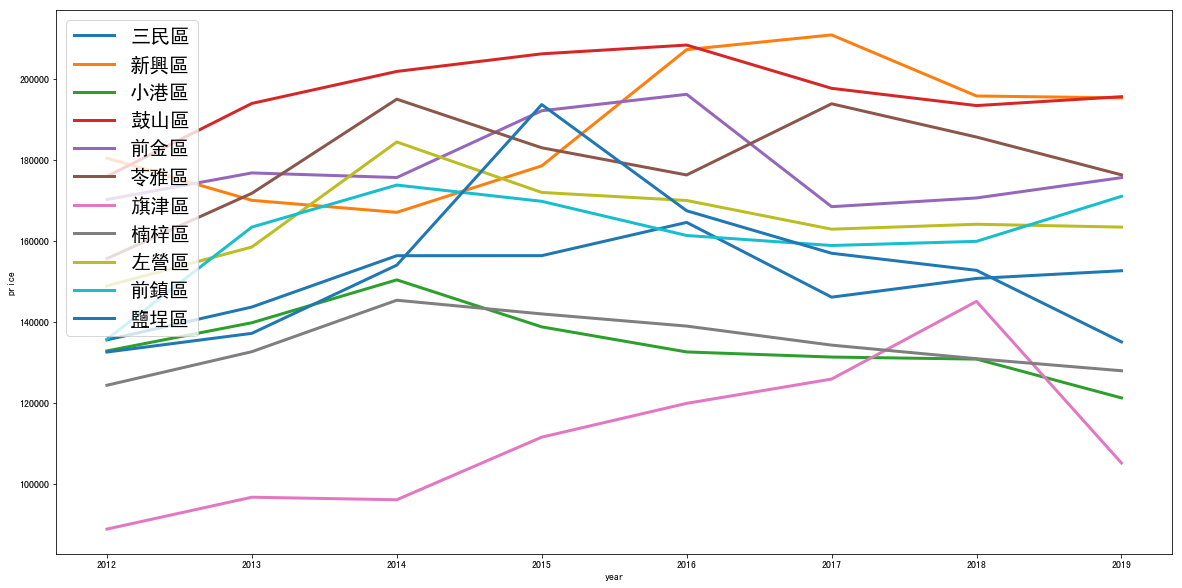

In [17]:
plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['axes.unicode_minus']=False
price_history.plot(figsize=(20,10),linewidth = 3)
plt.legend( labels = price_history.columns, loc = 'upper left',fontsize=20)
plt.figsize=(20,10)
plt.ylabel('price')
plt.xlabel('year')
##鼓山區的房價一直區於高處(但也挺保值沒有往下掉),新興區突然往上爬（是最近有什麼高級建案嗎)，苓雅區和前金區一直上上下下的價格
#最近開始前鎮區的單價開始超過左營區,三民區算是高雄區中等房價
#鹽埕區的單價好像不保值2015後一直快速往下掉,而楠梓區單價平穩但算是高雄區僅高過小港和旗津區

Text(0.5, 0, 'year')

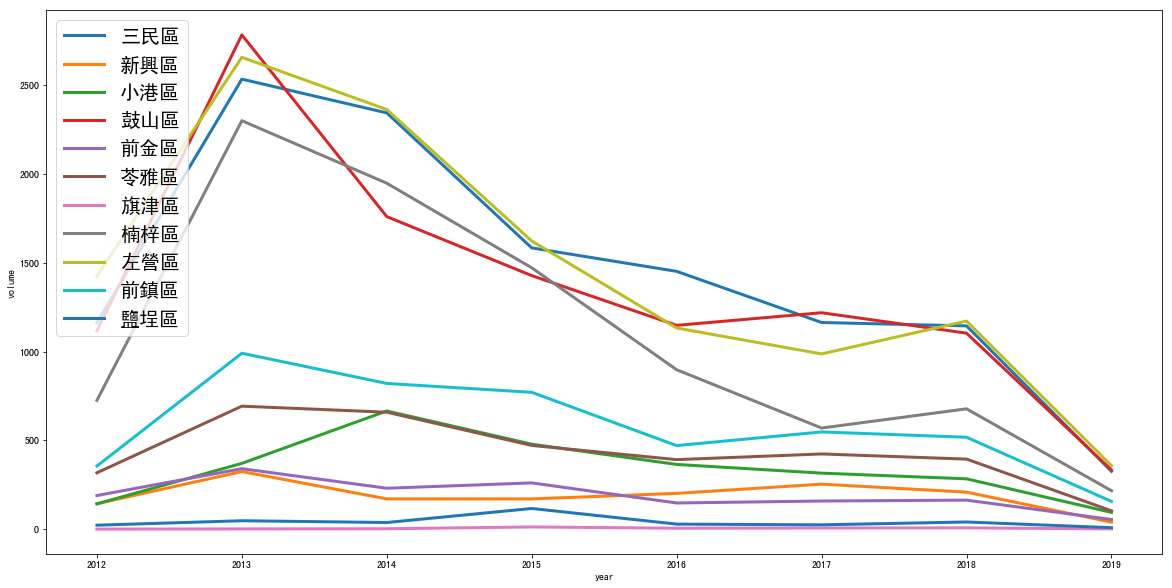

In [18]:
#高雄市交易量
volume = {}
for district in set(df_city['鄉鎮市區']):
    cond = (
        (df_city['主要用途'] == '住家用')
        & (df_city['鄉鎮市區'] == district)
        & (df_city['單價元坪'] < df_city["單價元坪"].quantile(0.95))
        & (df_city['單價元坪'] > df_city["單價元坪"].quantile(0.05))
        )
    groups = df_city[cond]['year']
    volume[district] = df_city[cond]['單價元坪'].astype(float).groupby(groups).count().loc[2012:]
volume_history = pd.DataFrame(volume)

volume_history.plot(figsize=(20,10),linewidth = 3)
plt.legend( labels = volume_history.columns, loc = 'upper left',fontsize=20)
plt.figsize=(20,10)
plt.ylabel('volume')
plt.xlabel('year')
#交易量 都由2013年開始往下掉，看起來 目前交易量多的也落在 鼓山，左營，三民(三者比較接近的成交量)
#楠梓的成交量看起來有掉比較多的現象（難道發現真的離市區太遙遠了)

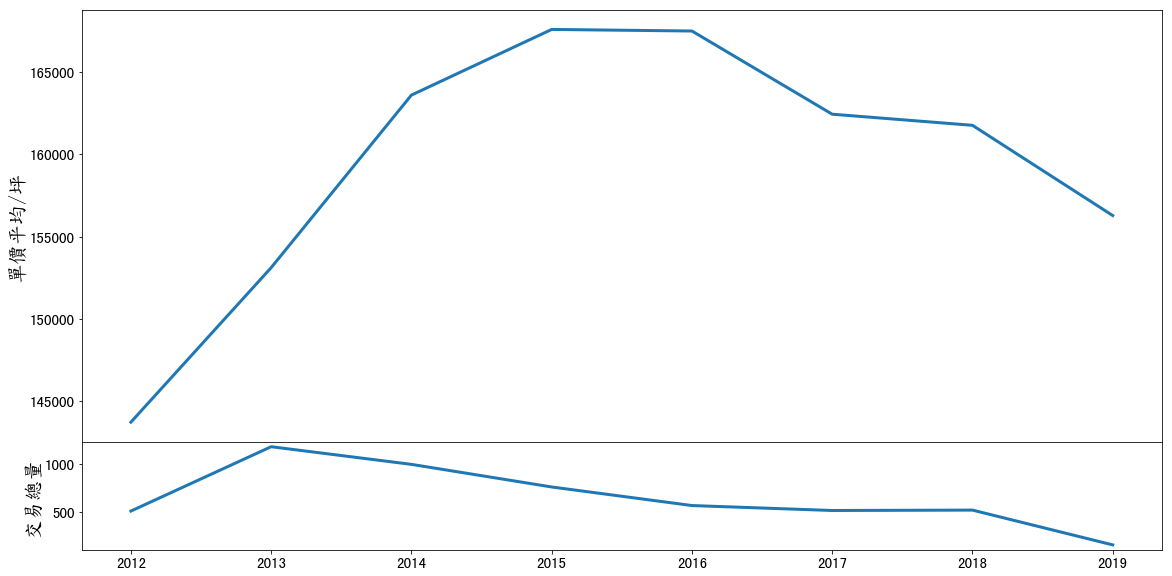

In [76]:
#總體高雄市房價與交易量比較
fig = plt.figure(figsize=(15, 15))
ax = fig.add_axes([0,0.3,1,0.4])
ax2 = fig.add_axes([0,0.2,1,0.1])

ax.set_ylabel('單價平均/坪',fontproperties=font,fontsize=20)
ax.tick_params(axis='both',labelsize=15)
ax.plot(price_history.mean(axis=1), label='單價平均',linewidth = 3)
ax2.set_ylabel('交易總量',fontproperties=font,fontsize=20)
ax2.tick_params(axis='both',labelsize=15)
ax2.plot(volume_history.mean(axis=1), label='總交易數量',linewidth = 3)

#交易量在2013年價格起飛時達到交易量最高峰，但2016年房價持續下跌但交易量就趨於平緩, 2019僅有兩季未參考

In [19]:
#建物類型交易量比較
building_type_prices = {}
building_type_volume = {}
for building_type in set(df['建物型態2']):
    cond = (
        (df['主要用途'] == '住家用')
        & (df['單價元坪'] < df["單價元坪"].quantile(0.8))
        & (df['單價元坪'] > df["單價元坪"].quantile(0.2))
        & (df['建物型態2'] == building_type)
        )
    building_type_prices[building_type] = df[cond]['單價元坪'].groupby(df[cond]['year']).mean().loc[2012:]
    building_type_volume[building_type] = df[cond]['單價元坪'].groupby(df[cond]['year']).count().loc[2012:]
plt.rcParams['font.sans-serif']=['SimHei'] 
building_price=pd.DataFrame(building_type_prices)[['公寓', '住宅大樓', '套房', '華廈','透天厝']]
building_volume=pd.DataFrame(building_type_volume)[['公寓', '住宅大樓', '套房', '華廈','透天厝']]


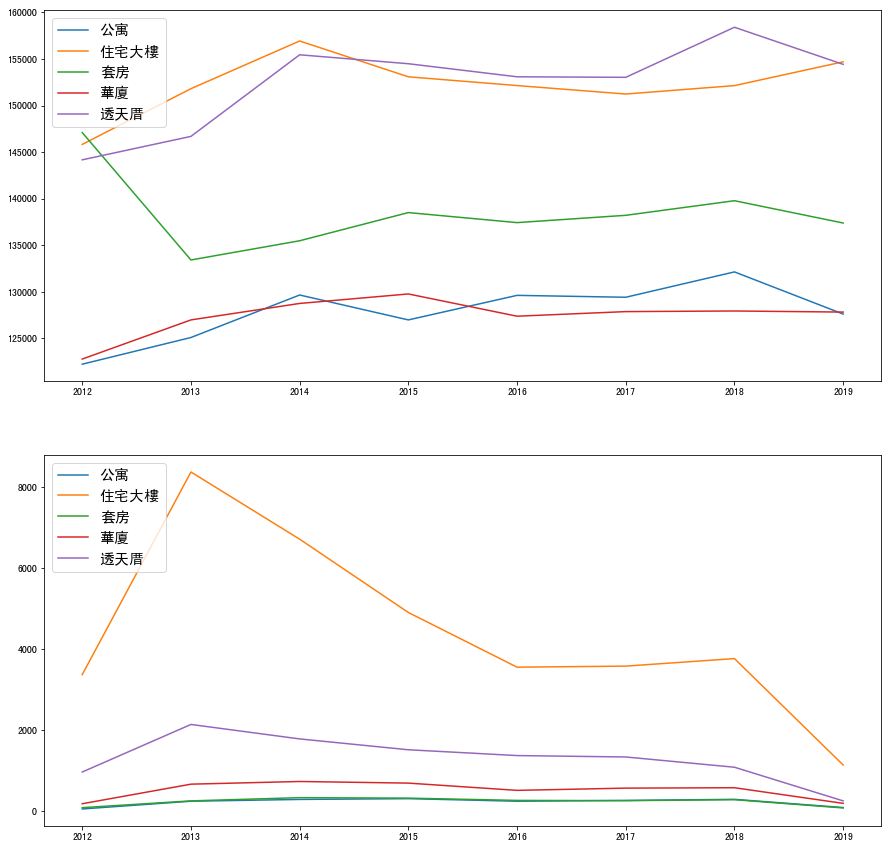

In [78]:
plt.figure(figsize=(15, 15))
plt.subplot(211)
plt.plot(building_price)
plt.legend( labels = building_price.columns, loc = 'upper left',fontsize=15)
plt.subplot(212)
plt.plot(building_volume)
plt.legend( labels = building_volume.columns, loc = 'upper left',fontsize=15)
#大樓與透天厝的單價還是比較高,價格還差不多貴,目前平均高雄市單價在15~16萬左右,居然華夏和公寓的價格比套房單價還低
#交易量來看還是大家都在買大樓多，再來就是透天厝,而公寓量少到一年交易不到300件印不出來,果然老舊公寓很難處理呀

In [59]:
##高雄到底有多少豪宅呢,超過100坪的房子
df_rich=df[(df['建物移轉面積坪數']>100)&(df['建物型態2']=='住宅大樓')]

Text(0, 0.5, '數量')

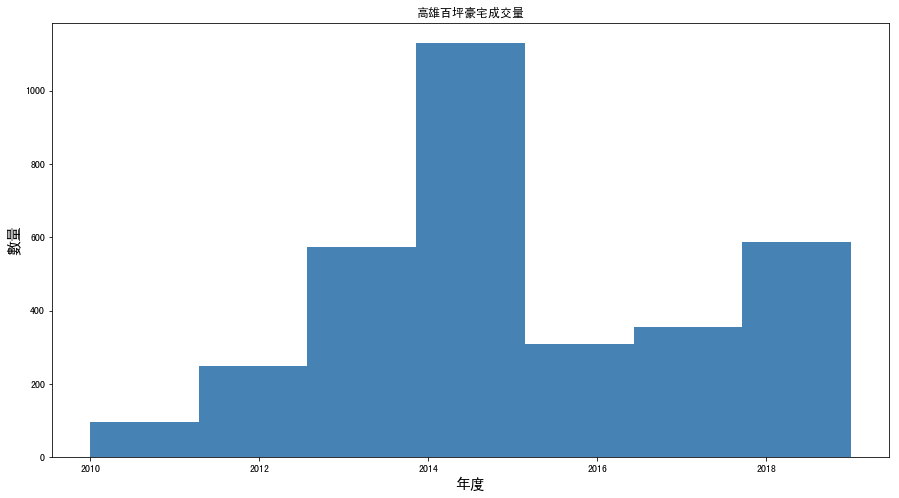

In [79]:
plt.figure(figsize=(15, 8))
plt.hist(df_rich.year, 
         bins=7,
         color = 'steelblue')
plt.title('高雄百坪豪宅成交量')
plt.xlabel('年度',fontsize=15)
plt.ylabel('數量',fontsize=15)
#有錢人在2014和2015都在買亳宅，但過後雖然有跌落，但近幾年每年持續慢慢往上爬